# Assignment 3

## Part 2: Regression modelling using mixture of experts
![](paste_images/2023-04-18-19-57-36.png)
![](paste_images/2023-04-18-19-57-53.png)

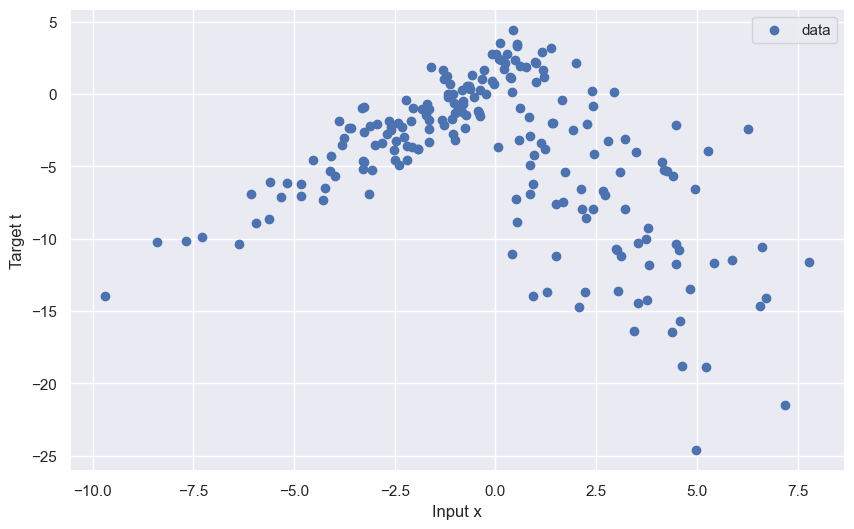

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()

data = np.load('./data_assignment3.npz')
x, t = data['x'], data['t']


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, t, marker='o', c='b', label='data')
ax.set(xlabel='Input x', ylabel='Target t')
ax.legend()

plt.show()

### Task 2.1
![](paste_images/2023-04-18-20-00-50.png)

We start by defining

\begin{equation}
\boldsymbol{\theta} = \{ \boldsymbol{w}_0, \boldsymbol{w}_1, \boldsymbol{v}, \sigma_0^2, \sigma_1^2, \tau \}
\end{equation}

where $\mathbf{w}_0$ and $\mathbf{w}_1$ are the weights of the two experts, $\mathbf{v}$ is the weight of the latent function describing when to use which expert, $\sigma_0^2$ and $\sigma_1^2$ are the variances of the two experts, and $\tau$ is the variance of the priors on the weights. As we use the same $\tau$ the two experts and the latent function will share the same prior.

The given joint model is then

\begin{equation}
\begin{aligned}
p(\boldsymbol{t}, \boldsymbol{\theta}, \boldsymbol{z}) =&  {\left[\prod_{n=1}^N \mathcal{N}\left(t_n | \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n | \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)\right] \mathcal{N}\left( \boldsymbol{w}_0 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) } \\
    & \mathcal{N}\left(\boldsymbol{w}_1 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}\left(\boldsymbol{v} \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}_{+}\left(\tau^2 \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_0 \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_1 \mid 0,1\right)
\end{aligned}
\end{equation}


To obtain the marginalized distribution $p(\boldsymbol{t}, \boldsymbol{\theta})$ the sum rule 

\begin{equation}
p(\boldsymbol{t}, \boldsymbol{\theta}) = \sum_{\boldsymbol{z}} p(\boldsymbol{t}, \boldsymbol{\theta}, \boldsymbol{z})
\end{equation}


To marginalize out each $z_n$ we first notice that $z_n$ is only present in the term

\begin{equation*}
\prod_{n=1}^N \mathcal{N}\left(t_n | \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n | \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)
\end{equation*}

and we can thus focus on this term when summing and insert it into the joint distribution afterwards. Writing up the marginalized joint distribution we get

\begin{equation}
\begin{aligned}
\sum_{\boldsymbol{z}} \prod_{n=1}^N \mathcal{N}\left(t_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right) &= \prod_{n=1}^N \sum_{z_n} \mathcal{N}\left(t_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right) \\
&= \prod_{n=1}^N  \left[ \mathcal{N}\left(t_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right) \left(1 -  \operatorname{Ber}\left(z_n = 1 \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)\right)  + 
\mathcal{N}\left(t_n \mid \boldsymbol{w}_{1}^T \boldsymbol{x}_n, \sigma_{1}^2\right)  \operatorname{Ber}\left(z_n = 1 \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right) \right]
\end{aligned}
\end{equation}

We can now write out the joint model

\begin{equation}
\begin{aligned}
p(\boldsymbol{t}, \boldsymbol{\theta}) =&  {\left[\prod_{n=1}^N  \left[ \mathcal{N}\left(t_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right) \left(1 -  \operatorname{Ber}\left(z_n = 1 \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)\right)  + 
\mathcal{N}\left(t_n \mid \boldsymbol{w}_{1}^T \boldsymbol{x}_n, \sigma_{1}^2\right)  \operatorname{Ber}\left(z_n = 1 \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right) \right]\right] \mathcal{N}\left(\boldsymbol{w}_0 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) } \\
    & \mathcal{N}\left(\boldsymbol{w}_1 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}\left(\boldsymbol{v} \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}_{+}\left(\tau^2 \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_0 \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_1 \mid 0,1\right)
\end{aligned}
\end{equation}

where $z_n$ has been marginalized out and the likelihood is then a mixture of two Gaussians weighted by the Bernoulli distribution of $z_n$.

### Task 2.2
![](paste_images/2023-04-18-20-00-40.png)

In [54]:
from scipy.stats import norm, bernoulli, multivariate_normal

def log_halfnormal(x):
    if x < 0: # negative values not supported
        return -np.Inf
    else:
        return np.log(2) + norm.logpdf(x, 0, 1)
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))

labels = ['$w_0$ (slope)', '$w_0$ (intercept)','$w_1$ (slope)', '$w_1$ (intercept)', 
           '$v$ (slope)', '$v$ (intercept)', '$\\tau$', '$\\sigma_0$', '$\\sigma_1$']

def extract_params(theta):
    assert len(theta) == 9
    
    w0 = theta[0:2] # both slope and intercept
    w1 = theta[2:4] # both slope and intercept
    v = theta[4:6] # both slope and intercept
    tau = theta[6]
    sigma0 = theta[7]
    sigma1 = theta[8]
    
    return w0, w1, v, tau, sigma0, sigma1

def log_joint_marginalized(theta: np.ndarray):
    # extract parameters
    w0, w1, v, tau, sigma0, sigma1 = extract_params(theta)
    
    # create data
    x_ = np.concatenate([x.reshape(-1, 1), np.ones((x.shape[0], 1))], axis=1)
    t_ = t.copy()
    
    # compute log joint
    D = x_.shape[1]
    
    p1 = np.log(
            norm.pdf(t_, x_@w0, sigma0) * bernoulli.pmf(0, sigmoid(x_@v)) + \
            norm.pdf(t_, x_@w1, sigma1) * bernoulli.pmf(1, sigmoid(x_@v))
        ).sum()
    
    p2 = multivariate_normal.logpdf(w0, np.zeros(D), tau * np.eye(D))
    p3 = multivariate_normal.logpdf(w1, np.zeros(D), tau * np.eye(D))
    p4 = multivariate_normal.logpdf(v, np.zeros(D), tau * np.eye(D))
    p5 = log_halfnormal(tau)
    p6 = log_halfnormal(sigma0)
    p7 = log_halfnormal(sigma1)
    
    return p1 + p2 + p3 + p4 + p5 + p6 + p7

# test
w0 = [0, 0]
w1 = [0, 0]
v = [0, 0]
tau = 1
sigma0 = 1
sigma1 = 1
theta = np.array([*w0, *w1, *v, tau, sigma0, sigma1])

p = log_joint_marginalized(theta)
    
    
assert np.isclose(p, -4923.785191568969)
    

### Task 2.3
![](paste_images/2023-04-18-20-01-09.png)

We will start by implementing the Metroplis-Hastings algorithm for the given model. Here we will use our answer from part 1 of the week 7 exercise. Here we assumed a gaussian proposal distribution which was symmetric. We will therefore extend the code to use an arbritrary proposal distribution. 

In [124]:
def metropolis(log_joint, num_params, tau, num_iter, theta_init=None, seed=None):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_joint:          function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer or None)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 
    
    # prevent progress bar from causing issues
    if hasattr(tqdm,'_instances'):
        tqdm._instances.clear()
    
    if seed is not None:
        np.random.seed(seed)

    if theta_init is None:
        theta_init = np.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_joint(theta_init)
    
    for k in tqdm(range(num_iter)):

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + np.random.normal(0, tau, size=(num_params))
        theta_star = np.clip(theta_star, np.array([-np.inf]*6 + [1e-8]*3), np.inf)
        # theta_star = theta_cur + np.random.uniform(0, tau, size=(num_params))
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_joint(theta_star)

        # compute acceptance probability
        # if not symmetric:
            # log_q_theta_star = log_npdf(theta_star, theta_cur, tau**2) # q(theta_star | theta_cur), used for denominator
            # log_q_theta = log_npdf(theta_cur, theta_star, tau**2) # q(theta_cur | theta_star), used for numerator
            # log_r = log_p_theta_star + log_q_theta - log_p_theta - log_q_theta_star
        # else:
        log_r = log_p_theta_star - log_p_theta
        A = min(1, np.exp(log_r))
        
        # accept new candidate with probability A
        if np.random.uniform() < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)
        
    print('Acceptance ratio: %3.2f' % np.mean(accepts))
        
    thetas = np.stack(thetas)
    return thetas


# sanity check: estimate the mean and variance of a N(x|1,3) Gaussian distribution
w0 = [0, 0]
w1 = [0, 0]
v = [0, 0]
tau = 1
sigma0 = 1
sigma1 = 1
theta = np.array([*w0, *w1, *v, tau, sigma0, sigma1])

iter = 50000
thetas = metropolis(log_joint_marginalized, 9, .01, iter, theta_init=theta, seed=0)
warm_up = int(0.1 * iter)


100%|██████████| 50000/50000 [00:58<00:00, 855.21it/s]


Acceptance ratio: 0.89


Let's plot the trace of the parameters to see if the chain has converged.

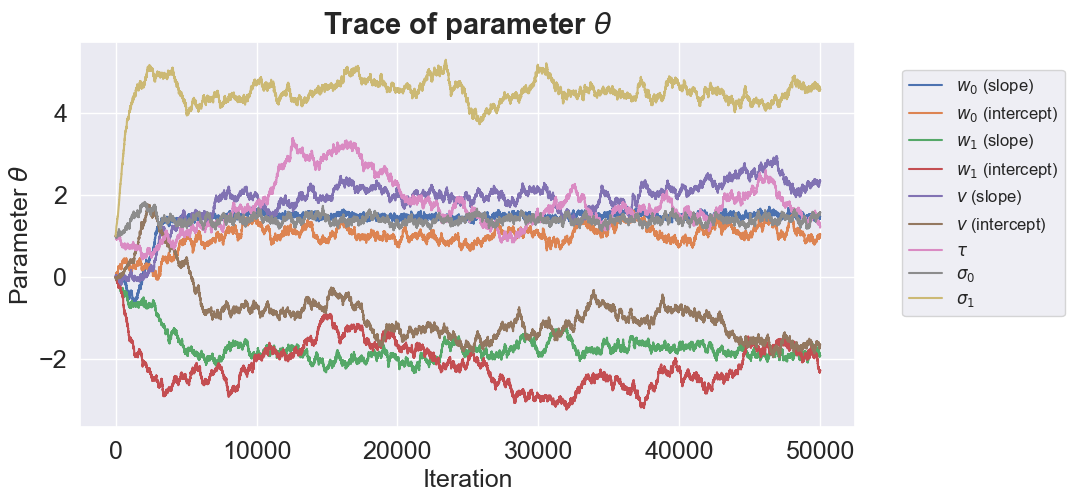

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

lineObjects = ax.plot(thetas)

ax.set_xlabel('Iteration')
ax.set_ylabel('Parameter $\\theta$')
ax.set_title('Trace of parameter $\\theta$', fontweight='bold')

ax.legend(lineObjects, labels, bbox_to_anchor = (1.05, 0.95), ncol=1, fontsize=12)

plt.show()

We can also have a look at how the parameters are distributed.

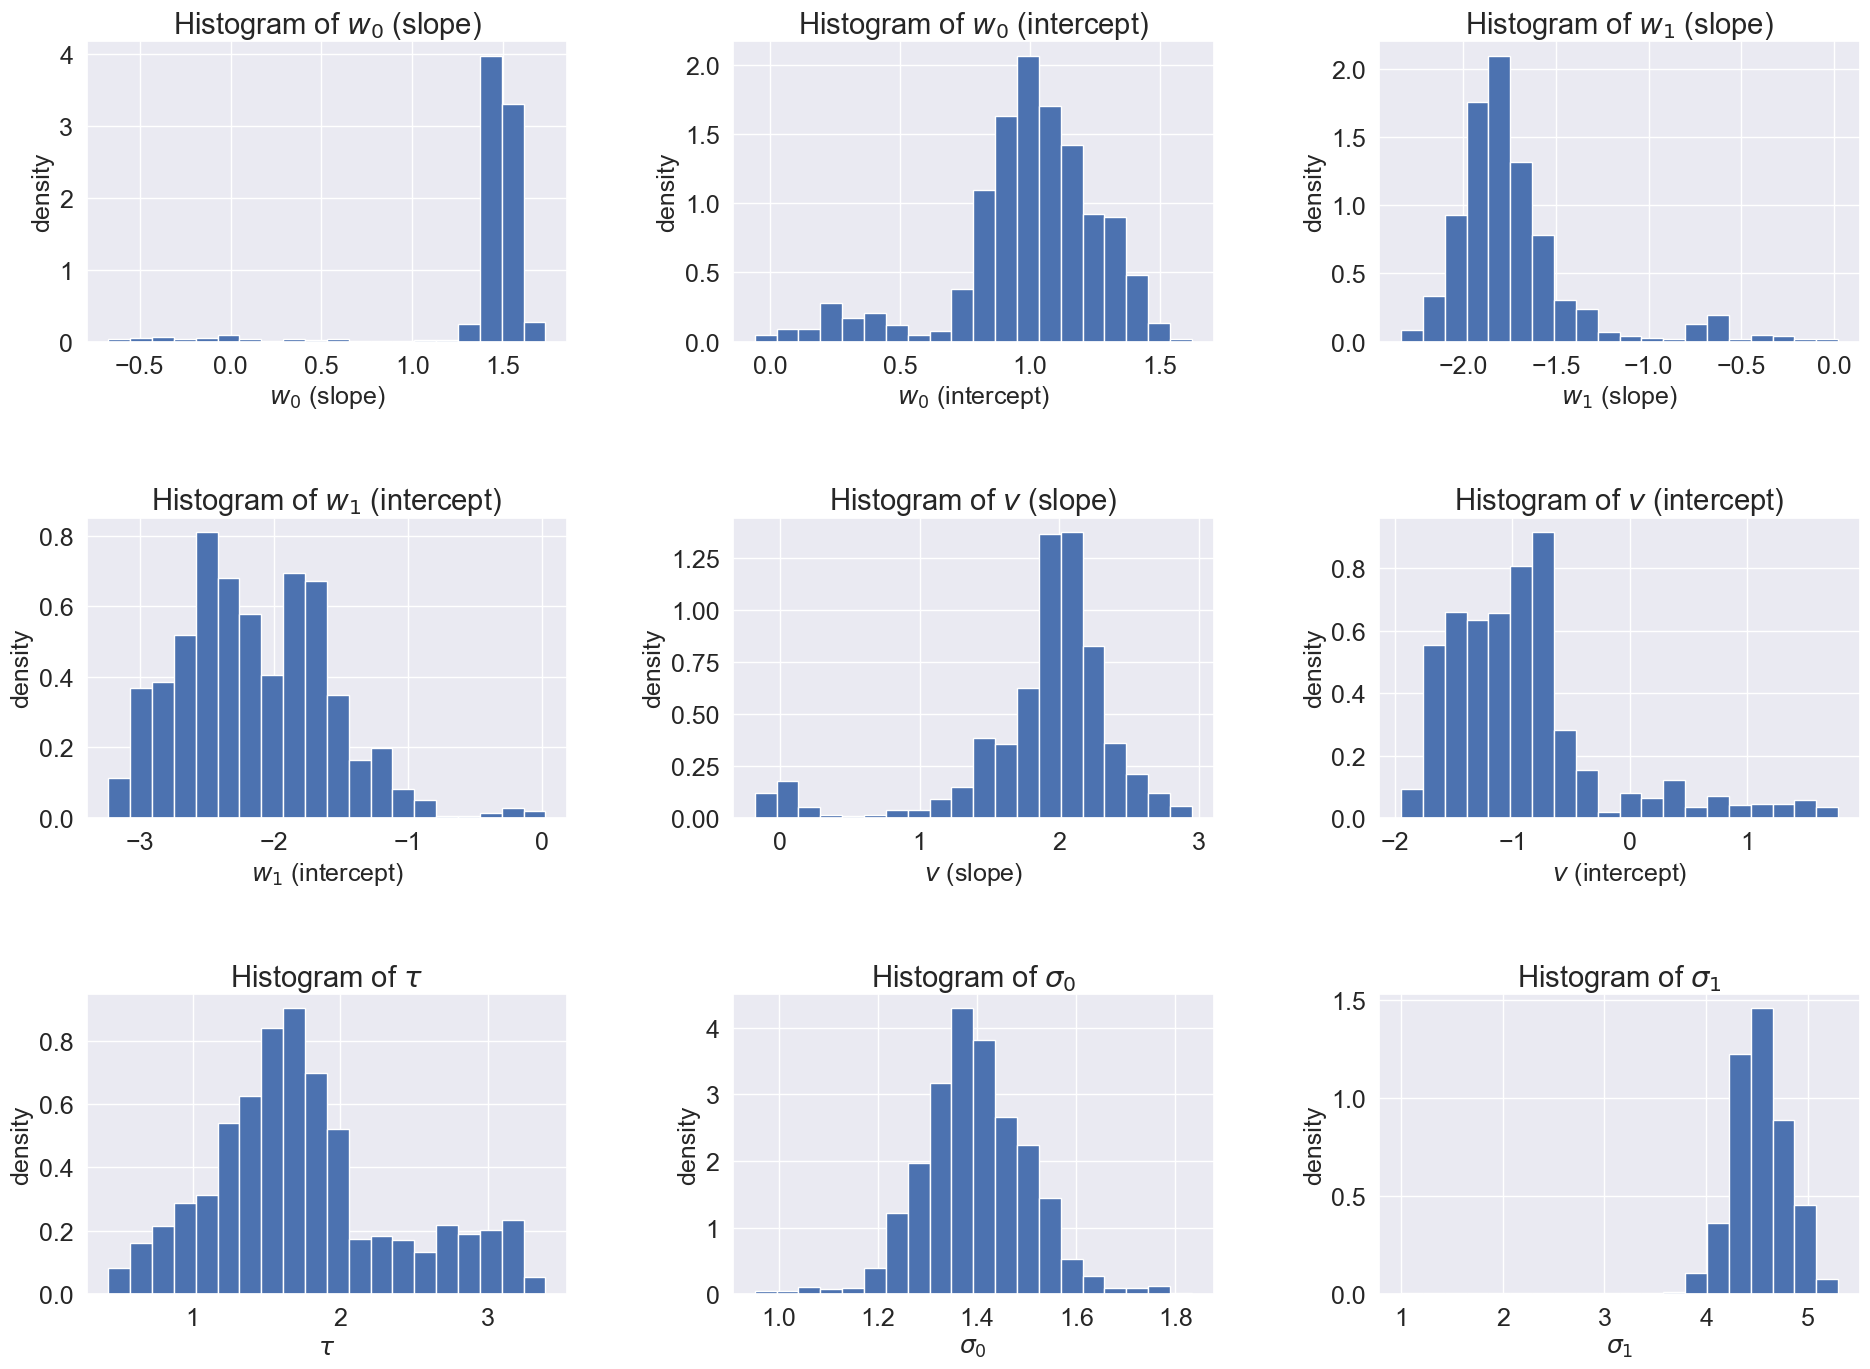

In [126]:
# set text size
s = 18
plt.rcParams.update({'xtick.labelsize': s, 'ytick.labelsize': s, 'axes.labelsize': s, 'axes.titlesize': int(1.2*s)})


fig ,axes = plt.subplots(3, 3, figsize=(20, 15))

for i in range(3):
    for j in range(3):
        idx = i*3+j
        axes[i, j].hist(thetas[:, idx], density=True, bins=20)
        axes[i, j].set(xlabel = labels[idx], ylabel = 'density', title = 'Histogram of ' + labels[idx])
        

# fig.suptitle('Histograms of all parameters', fontweight='bold', fontsize=25)
fig.tight_layout()

plt.show()

And taken a warmup period into account:

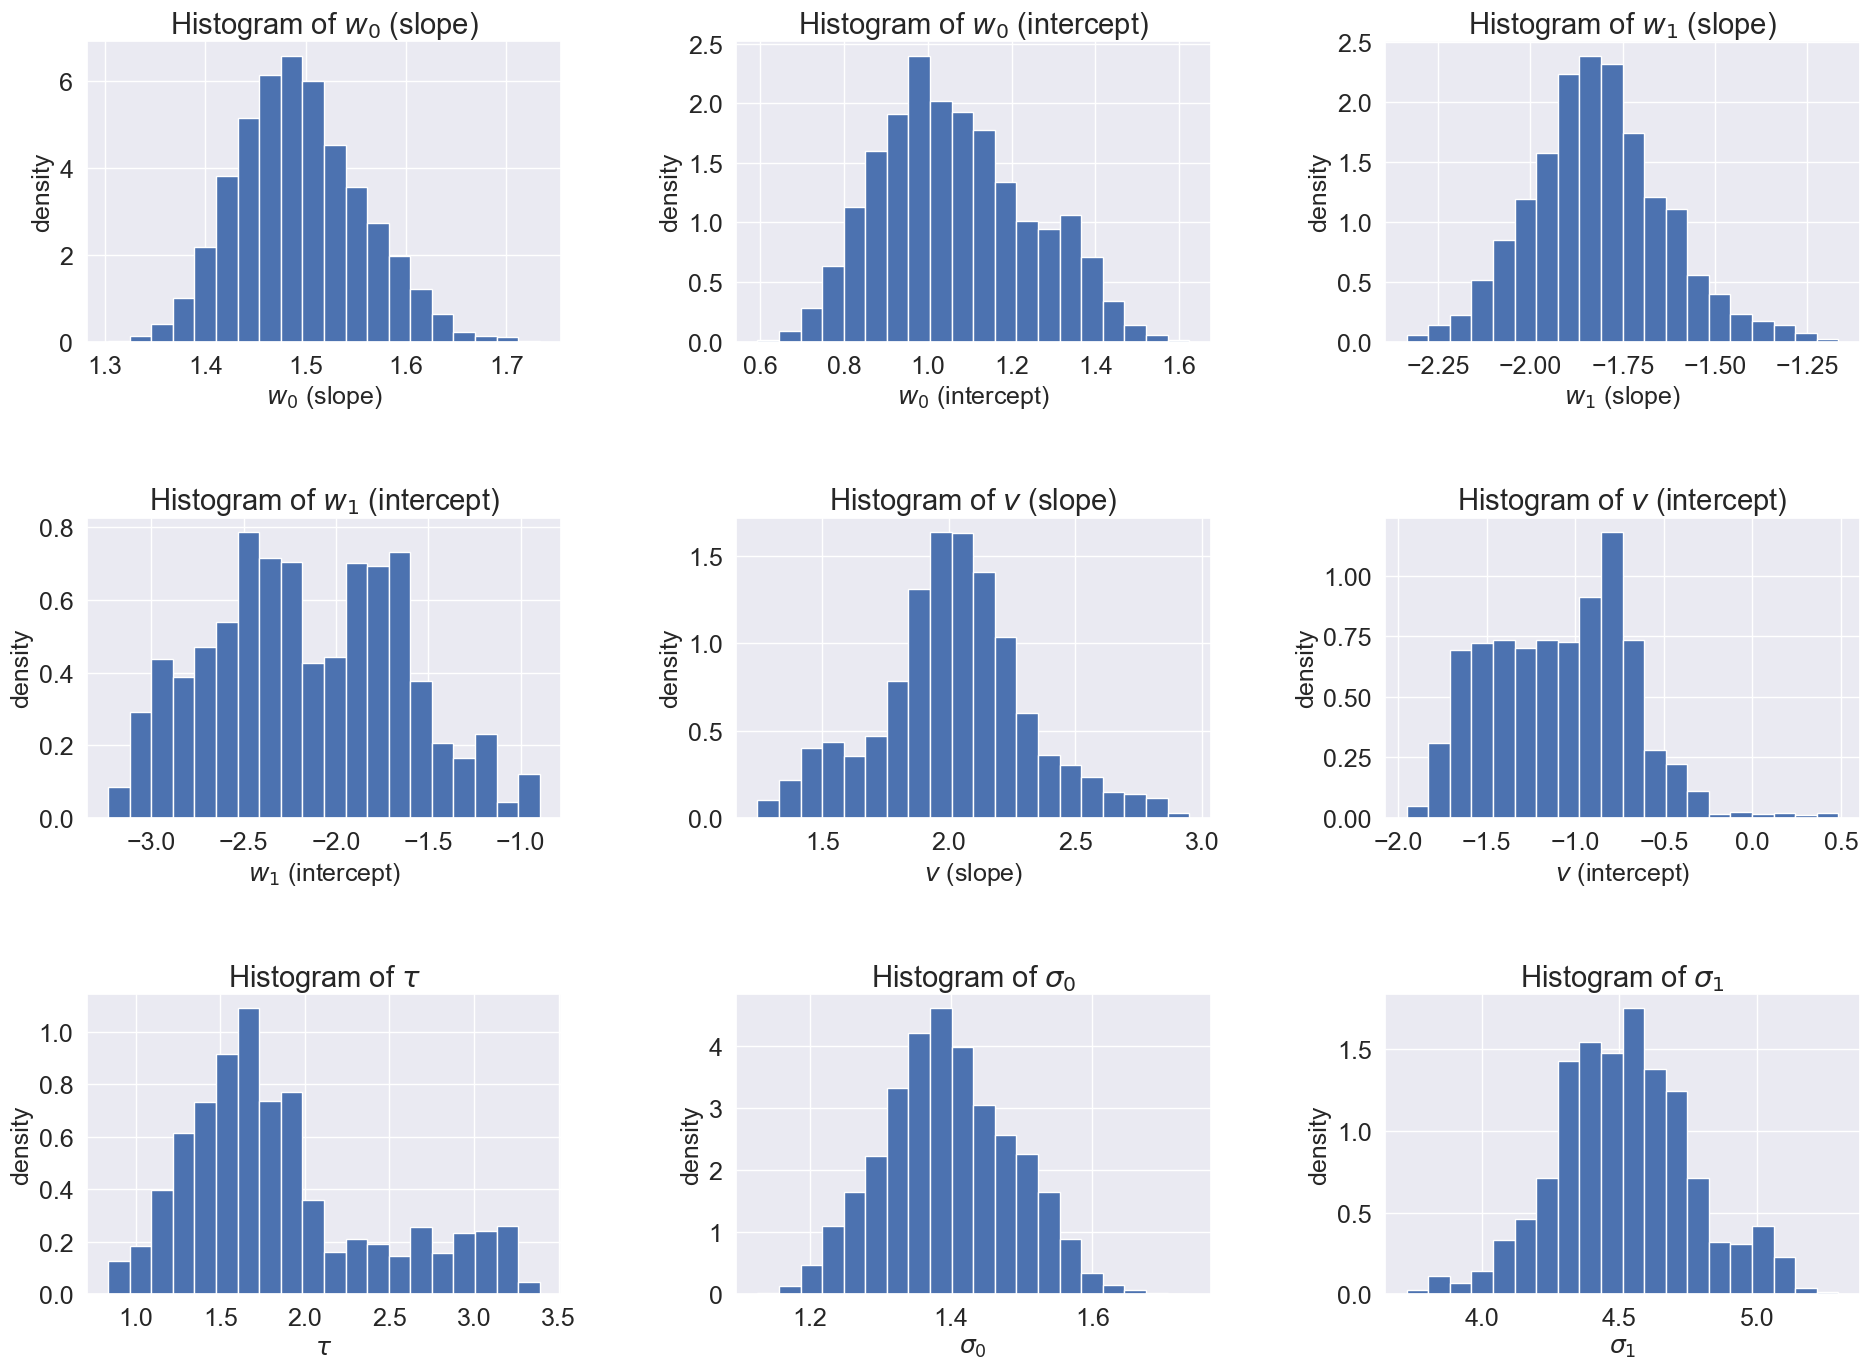

In [127]:
fig ,axes = plt.subplots(3, 3, figsize=(20, 15))

for i in range(3):
    for j in range(3):
        idx = i*3+j
        axes[i, j].hist(thetas[warm_up:, idx], density=True, bins=20)
        axes[i, j].set(xlabel = labels[idx], ylabel = 'density', title = 'Histogram of ' + labels[idx])
        

# fig.suptitle('Histograms of all parameters', fontweight='bold', fontsize=25)
fig.tight_layout()

plt.show()

We now compute the posterior mean and plot the resulting function.

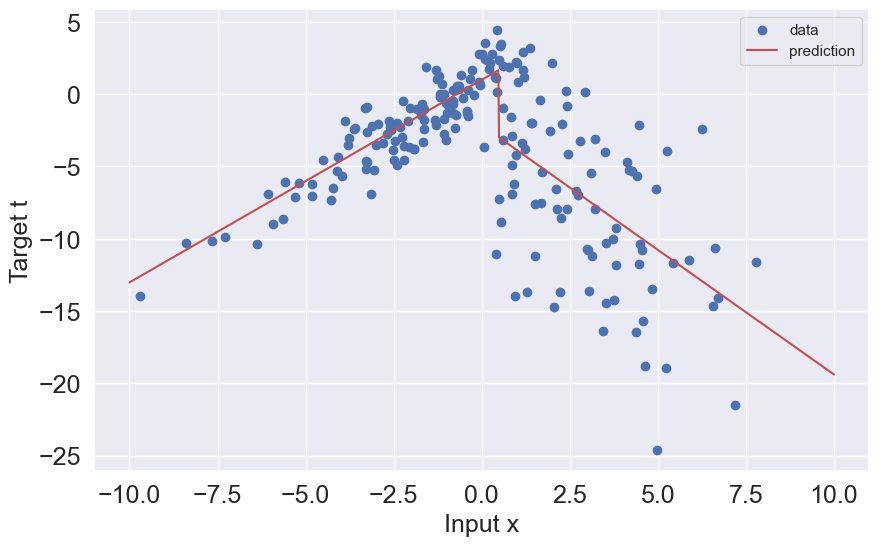

In [150]:
xs = np.linspace(-10, 10, 1000)
xs = np.stack([xs, np.ones_like(xs)], axis=1)





def predict(x, thetas, deterministic=True):
    # compute posterior mean
    posterior_means = thetas.mean(axis = 0)

    # extract parameters
    w0_hat, w1_hat, v_hat, tau_hat, sigma0_hat, sigma1_hat = extract_params(posterior_means)
    
    if deterministic:
        # calculate hidden variable 
        zs = sigmoid(v_hat@xs.T) > 0.5
        
        # caclualte predictions
        t_hat = w0_hat @xs.T * (1-zs) + w1_hat @xs.T * zs 
        
    else:
        # sample hidden variables
        zs = stats.bernoulli.rvs(sigmoid(v_hat@xs.T))
        
        # sample predictions
        t_hat = stats.norm.rvs(w0_hat @xs.T, sigma0_hat) * (1-zs) + stats.norm.rvs(w1_hat @xs.T, sigma1_hat) * zs + stats.norm.rvs(0, tau_hat)

    return t_hat


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, t, marker='o', c='b', label='data')
ax.plot(xs[: ,0], predict(xs, thetas), c='r', label='prediction')
ax.set(xlabel='Input x', ylabel='Target t')
ax.legend()

plt.show()

### Task 2.4
![](paste_images/2023-04-18-20-01-30.png)

In [170]:
posterior_means = thetas.mean(axis = 0)
cred_int_lower = np.quantile(thetas, 0.025, axis=0)
cred_int_upper = np.quantile(thetas, 0.975, axis=0)

print("-" *10, "Parameter estimates including burn-in period", "-" *10)
print()
print(f"{'Parameter': <20} {'Posterior mean': <20} {'95% credible interval': <20}")
print("")
for i in range(9):
    print(f"{labels[i]: <20} {posterior_means[i].round(3): <20} {'[' + str(cred_int_lower[i].round(3)) + ',' + str(cred_int_upper[i].round(3)) +']': <20}")


posterior_means = thetas[warm_up:].mean(axis = 0)
cred_int_lower = np.quantile(thetas[warm_up:], 0.025, axis=0)
cred_int_upper = np.quantile(thetas[warm_up:], 0.975, axis=0)

print("")


print("-" *10, "Parameter estimates excluding burn-in period", "-" *10)
print()
print(f"{'Parameter': <20} {'Posterior mean': <20} {'95% credible interval': <20}")
print("")
for i in range(9):
    print(f"{labels[i]: <20} {posterior_means[i].round(3): <20} {'[' + str(cred_int_lower[i].round(3)) + ',' + str(cred_int_upper[i].round(3)) +']': <20}")


---------- Parameter estimates including burn-in period ----------

Parameter            Posterior mean       95% credible interval

$w_0$ (slope)        1.401                [-0.104,1.621]      
$w_0$ (intercept)    0.995                [0.221,1.419]       
$w_1$ (slope)        -1.725               [-2.151,-0.63]      
$w_1$ (intercept)    -2.146               [-3.043,-0.982]     
$v$ (slope)          1.865                [-0.006,2.653]      
$v$ (intercept)      -0.903               [-1.742,1.22]       
$\tau$               1.755                [0.696,3.177]       
$\sigma_0$           1.397                [1.203,1.62]        
$\sigma_1$           4.499                [3.859,5.062]       

---------- Parameter estimates excluding burn-in period ----------

Parameter            Posterior mean       95% credible interval

$w_0$ (slope)        1.494                [1.382,1.624]       
$w_0$ (intercept)    1.066                [0.758,1.425]       
$w_1$ (slope)        -1.816             

### Task 2.5
![](paste_images/2023-04-18-20-01-42.png)

### Task 2.6
![](paste_images/2023-04-18-20-02-08.png)

### Task 2.7
![](paste_images/2023-04-18-20-02-21.png)

## Appendix: other trials for a proposal distribution 



### General proposal distribution

In [113]:
from scipy import stats

class PropDist:
    def __init__(self):
        self.dists = []
        self.args = []
        self.kwargs = []
        self.names = []
        
    def rvs(self, theta_cur):
        # return np.random.multivariate_normal(self.mean, self.cov, size=size)
        # return [dist.rvs(*args, **kwargs) for dist, args, kwargs in zip(self.dists, self.args, self.kwargs)]
        theta_star = []
        for i, dist in enumerate(self.dists):
            # if isinstance(theta_cur[i], list):
            #     theta_star.append(dist.rvs(*theta_cur[i], **self.kwargs[i]))
            # else:
            theta_star.append(dist.rvs(theta_cur[i], **self.kwargs[i]))
        
        return theta_star
        
    
    def logpdf(self, theta1, theta2):
        logpdf = 0
        for i, dist in enumerate(self.dists):
            if isinstance(theta2[i], list):
                logpdf += dist.logpdf(theta1[i], *theta2[i], **self.kwargs[i])
            else:
                logpdf += dist.logpdf(theta1[i], theta2[i], **self.kwargs[i])
        return logpdf
        # return [dist.logpdf(theta1, *theta2[i] if isinstance(theta2[i], list) else theta2[i]) for i, dist in enumerate(self.dists)]
    
    def add_param(self, name, dist, *args, **kwargs):
        self.names.append(name)
        self.dists.append(dist)
        self.args.append(args)
        self.kwargs.append(kwargs)


def metropolis_hastings(log_joint, prop_dist, num_params, num_iter, theta_init=None, seed=None, clip = True):    
    """ Runs a Metropolis-Hastings sampler 
        Defualt proposal distribution is a normal distribution with mean 0 and variance 1.
    
        Arguments:
        log_joint:          function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer or None)
        prop_dist:          proposal distribution (scipy.stats distribution)
        prop_dist_args:     arguments for proposal distributionin the order they appear in scipy.stats, when calculating q, the first param will be overwritten by current values of theta (list)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
        
    """ 
    
    # prevent progress bar from causing issues
    if hasattr(tqdm,'_instances'):
        tqdm._instances.clear()
    
    if seed is not None:
        np.random.seed(seed)

    if theta_init is None:
        theta_init = np.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_joint(theta_init)
    
    for k in tqdm(range(num_iter)):

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        # theta_star = theta_cur + np.random.normal(0, tau, size=(num_params))
        # theta_star = theta_cur + prop_dist.rvs(*prop_dist_args, size=(num_params))
        # theta_star = [theta_cur[i] + param for i, param in enumerate(prop_dist.rvs())]
        theta_star = prop_dist.rvs(theta_cur)
        if clip:
            theta_star = np.clip(theta_star, np.array([-np.inf]*6 + [1e-8]*3), np.inf)
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_joint(theta_star)

        # compute acceptance probability
        # if not symmetric:
            # log_q_theta_star = log_npdf(theta_star, theta_cur, tau**2) # q(theta_star | theta_cur), used for denominator
            # log_q_theta = log_npdf(theta_cur, theta_star, tau**2) # q(theta_cur | theta_star), used for numerator
            # log_r = log_p_theta_star + log_q_theta - log_p_theta - log_q_theta_star
        # else:
        # log_r = log_p_theta_star - log_p_theta
        
        # log_q_theta_star = prop_dist.logpdf(theta_star, theta_cur, *prop_dist_args[1:]) # q(theta_star | theta_cur), used for denominator
        # log_q_theta = prop_dist.logpdf(theta_cur, theta_star, *prop_dist_args[1:]) # q(theta_cur | theta_star), used for numerator
        log_q_theta_star = prop_dist.logpdf(theta_star, theta_cur) # q(theta_star | theta_cur), used for denominator
        log_q_theta = prop_dist.logpdf(theta_cur, theta_star) # q(theta_cur | theta_star), used for numerator
        log_r = log_p_theta_star + log_q_theta - log_p_theta - log_q_theta_star
        A = min(1, np.exp(log_r))
        
        # accept new candidate with probability A
        if np.random.uniform() < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)
        
    print('Acceptance ratio: %3.2f' % np.mean(accepts))
        
    # thetas = np.stack(thetas)
    return thetas

##### TEST WITH EX 7 example #####

log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)
prop_dist = PropDist()
prop_dist.add_param('mu', stats.norm, scale = 2)

# sanity check: estimate the mean and variance of a N(x|1,3) Gaussian distribution
thetas = metropolis_hastings(lambda x: log_npdf(x[0], 1., 3.), prop_dist, 1, 10000, theta_init=np.array([0]), seed=0, clip = False)

# compute mean and variance and relative errors
mean_thetas, var_thetas = np.mean(thetas), np.var(thetas)
rel_err_mean, rel_err_var = (mean_thetas - 1.)/1., (var_thetas - 3.)/3.

print('\nSanity check:')
print(f'Mean:\t{mean_thetas:3.2f} (rel. err: {rel_err_mean:3.2f})')
print(f'Var:\t{var_thetas:3.2f} (rel. err: {rel_err_var:3.2f})')

if np.abs(rel_err_mean) < 0.05 and np.abs(rel_err_var) < 0.05:
    print('The relative errors for the first two central moments are less than 5%. Everything looks ok.')
else:
    print('The relative errors for the first two central moments are larger than 5%. Something is likely wrong. Check your implementation')



100%|██████████| 10000/10000 [00:02<00:00, 3480.46it/s]

Acceptance ratio: 0.68

Sanity check:
Mean:	0.98 (rel. err: -0.02)
Var:	2.97 (rel. err: -0.01)
The relative errors for the first two central moments are less than 5%. Everything looks ok.


In [119]:
theta_init = [
    0, 0, # w0
    0, 0, # w1
    0, 0, # v
    1, # tau
    1, # sigma0
    1, # sigma1
]
from scipy import stats
prop_var = 0.5
prop_dist = PropDist()
prop_dist.add_param('w0_slope', stats.norm, scale = prop_var)
prop_dist.add_param('w0_intercept', stats.norm, scale = prop_var)
prop_dist.add_param('w1_slope', stats.norm, scale = prop_var)
prop_dist.add_param('w1_intercept', stats.norm, scale = prop_var)
prop_dist.add_param('v_slope', stats.norm, scale = prop_var)
prop_dist.add_param('v_intercept', stats.norm, scale = prop_var)
prop_dist.add_param('tau', stats.halfnorm, scale = prop_var*0.5)
prop_dist.add_param('sigma0', stats.halfnorm, scale = prop_var*0.5)
prop_dist.add_param('sigma1', stats.halfnorm, scale = prop_var*0.5)

thetas = metropolis_hastings(log_joint_marginalized, prop_dist = prop_dist, num_params = 9, num_iter = 10000, theta_init=theta_init, seed=0)

100%|██████████| 10000/10000 [00:29<00:00, 343.01it/s]

Acceptance ratio: 0.00


In [ ]:
stats.halfnorm.lo

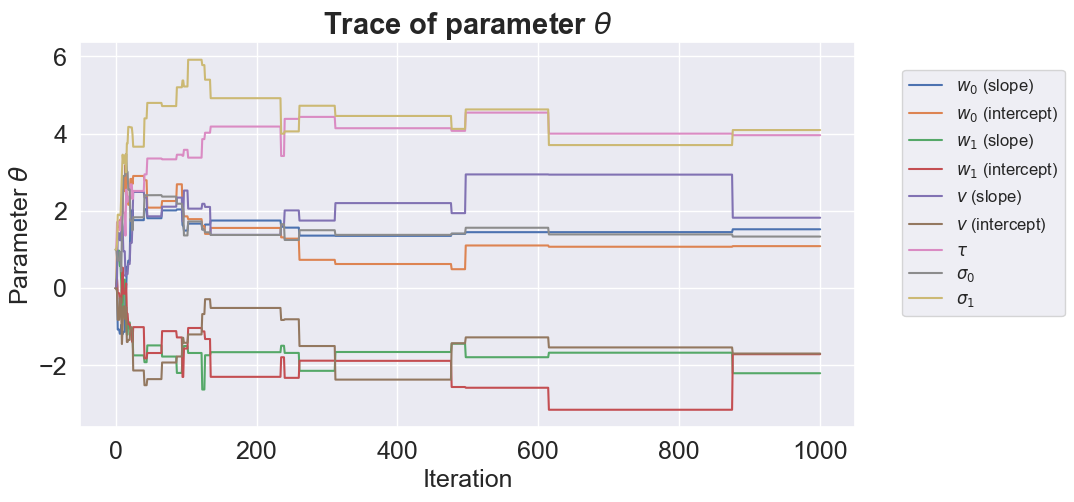

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

lineObjects = ax.plot(thetas)

ax.set_xlabel('Iteration')
ax.set_ylabel('Parameter $\\theta$')
ax.set_title('Trace of parameter $\\theta$', fontweight='bold')

ax.legend(lineObjects, labels, bbox_to_anchor = (1.05, 0.95), ncol=1, fontsize=12)

plt.show()

In [102]:
# from scipy import stats

# class PropDist:
#     def __init__(self):
#         self.dists = []
#         self.args = []
#         self.kwargs = []
#         self.names = []
        
#     def rvs(self, size=None):
#         # return np.random.multivariate_normal(self.mean, self.cov, size=size)
#         return [dist.rvs(*args, **kwargs) for dist, args, kwargs in zip(self.dists, self.args, self.kwargs)]
        
    
#     # def logpdf(self, x):
#         # return multivariate_normal.logpdf(x, self.mean, self.cov)
    
#     def add_param(self, name, dist, *args, **kwargs):
#         self.names.append(name)
#         self.dists.append(dist)
#         self.args.append(args)
#         self.kwargs.append(kwargs)

# def metropolis_hastings(log_joint, num_params, num_iter, theta_init=None, seed=None, prop_dist = stats.norm, prop_dist_args = [0, 1]):    
#     """ Runs a Metropolis-Hastings sampler 
#         Defualt proposal distribution is a normal distribution with mean 0 and variance 1.
    
#         Arguments:
#         log_joint:          function for evaluating the log joint distribution
#         num_params:         number of parameters of the joint distribution (integer)
#         tau:                variance of Gaussian proposal distribution (positive real)
#         num_iter:           number of iterations (integer)
#         theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
#         seed:               seed (integer or None)
#         prop_dist:          proposal distribution (scipy.stats distribution)
#         prop_dist_args:     arguments for proposal distributionin the order they appear in scipy.stats, when calculating q, the first param will be overwritten by current values of theta (list)

#         returns
#         thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
        
#     """ 
    
#     # prevent progress bar from causing issues
#     if hasattr(tqdm,'_instances'):
#         tqdm._instances.clear()
    
#     if seed is not None:
#         np.random.seed(seed)

#     if theta_init is None:
#         theta_init = np.zeros((num_params))
    
#     # prepare lists 
#     thetas = [theta_init]
#     accepts = []
#     log_p_theta = log_joint(theta_init)
    
#     for k in tqdm(range(num_iter)):

#         # get the last value for theta and generate new proposal candidate
#         theta_cur = thetas[-1]
#         # theta_star = theta_cur + np.random.normal(0, tau, size=(num_params))
#         theta_star = theta_cur + prop_dist.rvs(*prop_dist_args, size=(num_params))
        
#         # evaluate the log density for the candidate sample
#         log_p_theta_star = log_joint(theta_star)

#         # compute acceptance probability
#         # if not symmetric:
#             # log_q_theta_star = log_npdf(theta_star, theta_cur, tau**2) # q(theta_star | theta_cur), used for denominator
#             # log_q_theta = log_npdf(theta_cur, theta_star, tau**2) # q(theta_cur | theta_star), used for numerator
#             # log_r = log_p_theta_star + log_q_theta - log_p_theta - log_q_theta_star
#         # else:
#         # log_r = log_p_theta_star - log_p_theta
        
#         log_q_theta_star = prop_dist.logpdf(theta_star, theta_cur, *prop_dist_args[1:]) # q(theta_star | theta_cur), used for denominator
#         log_q_theta = prop_dist.logpdf(theta_cur, theta_star, *prop_dist_args[1:]) # q(theta_cur | theta_star), used for numerator
#         log_r = log_p_theta_star + log_q_theta - log_p_theta - log_q_theta_star
#         A = min(1, np.exp(log_r))
        
#         # accept new candidate with probability A
#         if np.random.uniform() < A:
#             theta_next = theta_star
#             log_p_theta = log_p_theta_star
#             accepts.append(1)
#         else:
#             theta_next = theta_cur
#             accepts.append(0)

#         thetas.append(theta_next)
        
#     print('Acceptance ratio: %3.2f' % np.mean(accepts))
        
#     thetas = np.stack(thetas)
#     return thetas

# ##### TEST WITH EX 7 example #####

# log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)

# # sanity check: estimate the mean and variance of a N(x|1,3) Gaussian distribution
# thetas = metropolis_hastings(lambda x: log_npdf(x, 1., 3.), 1, 10000, theta_init=np.array([0]), seed=0, prop_dist_args=[0, 2])

# # compute mean and variance and relative errors
# mean_thetas, var_thetas = np.mean(thetas), np.var(thetas)
# rel_err_mean, rel_err_var = (mean_thetas - 1.)/1., (var_thetas - 3.)/3.

# print('\nSanity check:')
# print(f'Mean:\t{mean_thetas:3.2f} (rel. err: {rel_err_mean:3.2f})')
# print(f'Var:\t{var_thetas:3.2f} (rel. err: {rel_err_var:3.2f})')

# if np.abs(rel_err_mean) < 0.05 and np.abs(rel_err_var) < 0.05:
#     print('The relative errors for the first two central moments are less than 5%. Everything looks ok.')
# else:
#     print('The relative errors for the first two central moments are larger than 5%. Something is likely wrong. Check your implementation')

We now infer the parameters of the model using the Metropolis-Hastings algorithm.